<a href="https://colab.research.google.com/github/Neafiol/Tinkoff/blob/master/Convolution_networks/convolution_nv_dz_lesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget "https://my-files.ru/Save/f5b8rn/lesh.rar" --no-check-certificate -O dataset.rar
! unrar x dataset.rar
# for i in tqdm(range(10)):
ls

--2019-02-16 05:13:51--  https://my-files.ru/Save/f5b8rn/lesh.rar
Resolving my-files.ru (my-files.ru)... 185.148.38.30
Connecting to my-files.ru (my-files.ru)|185.148.38.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: http://hm.l.mf-arch.ru/d/eyJ0IjoiMjAxOS0wMi0xNlQwNToxMzo1NC4wMTEwMTE5WiIsInRtIjoxNSwiYmQiOjEsImZkIjo1NjM5NjcxLCJyZiI6bnVsbCwic2wiOjMwLCJmbiI6Imxlc2gucmFyIiwiciI6Imh0dHBzOi8vbXktZmlsZXMucnUvZjViOHJuIiwibCI6bnVsbH0,.248ACA6FDE2F3F7D405545EF018AB4BA./lesh.rar [following]
--2019-02-16 05:13:52--  http://hm.l.mf-arch.ru/d/eyJ0IjoiMjAxOS0wMi0xNlQwNToxMzo1NC4wMTEwMTE5WiIsInRtIjoxNSwiYmQiOjEsImZkIjo1NjM5NjcxLCJyZiI6bnVsbCwic2wiOjMwLCJmbiI6Imxlc2gucmFyIiwiciI6Imh0dHBzOi8vbXktZmlsZXMucnUvZjViOHJuIiwibCI6bnVsbH0,.248ACA6FDE2F3F7D405545EF018AB4BA./lesh.rar
Resolving hm.l.mf-arch.ru (hm.l.mf-arch.ru)... 78.107.232.247
Connecting to hm.l.mf-arch.ru (hm.l.mf-arch.ru)|78.107.232.247|:80... c

NameError: ignored

In [4]:
ls 

dataset.rar  lesh/  sample_data/


In [0]:
from torchvision import transforms
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

In [0]:
import os
from tqdm import tqdm
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        device = torch.device('cuda:0')
      
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        X=X.to(device)
        Y=Y.to(device)

        return X, Y

In [9]:
dataset = ColorizationDataset('lesh', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 7067/7067 [00:36<00:00, 193.12it/s]


In [0]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            
            nn.Conv2d(32, 128, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            
            
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
   
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU()
            
            # ...
            # много-много таких же, но наоборот
            # ...
        )
        
        self.postconcat = nn.Sequential(
            nn.Conv2d(257, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [0]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    img=img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()
#     print("test color:")
#     print(img[0][0])
    return img
  
def to_numpy_grey_image(img):
    img=img.detach().cpu().view(128, 128).numpy()
    return img
  

In [0]:
num_epochs = 450
lr = 1e-3

device=torch.device('cuda:0')
model = Colorizer()#.to(device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


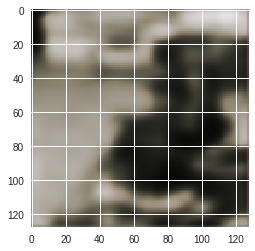

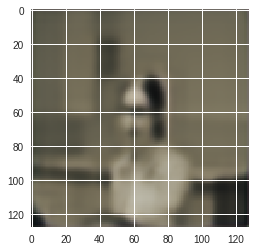

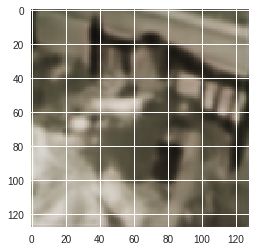

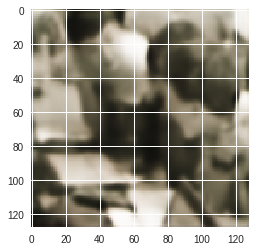

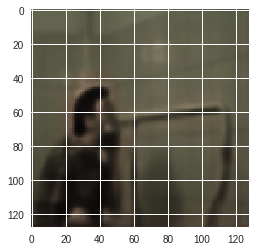

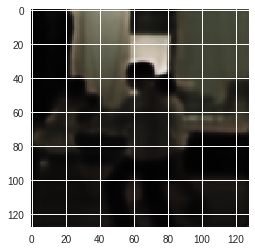

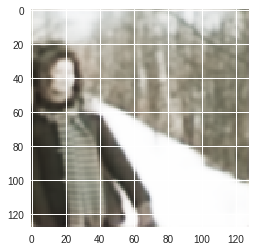

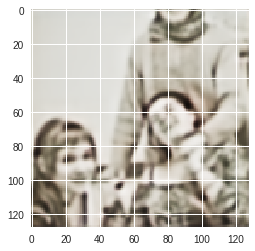

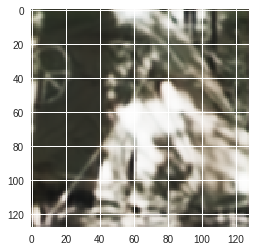

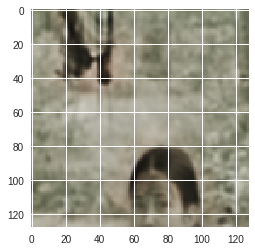

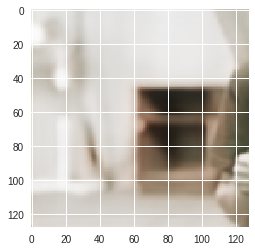

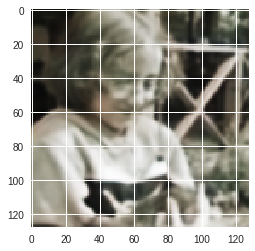

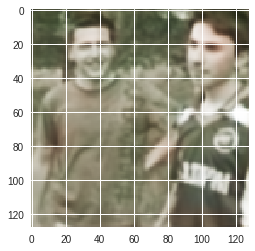

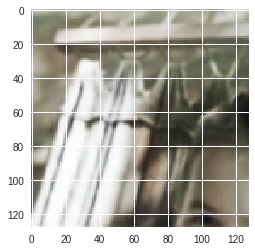

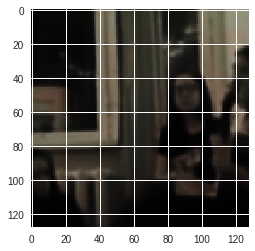

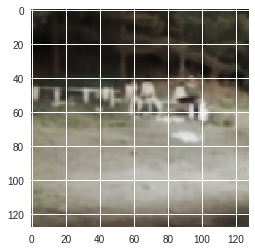

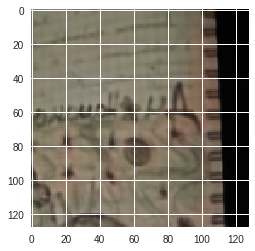

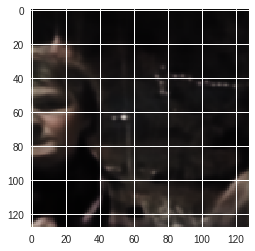

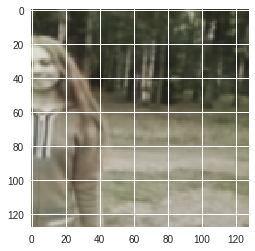

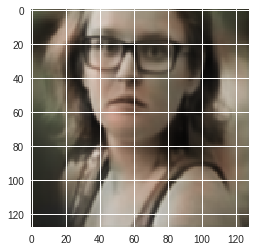

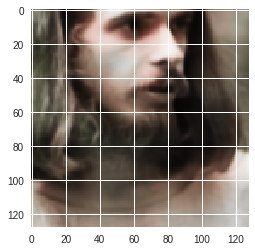

In [0]:
history = []
from google.colab import files

for epoch in range(1,num_epochs):
    for x, y in loader:
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать backward
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)
        #torch.nn.utils.clip_grad_norm_
        
        optimizer.zero_grad()

        output = model(x)
        t=output
        tx=x
        ty=y
        loss = criterion(output, y)
        loss.backward() 
#         torch.nn.utils.clip_grad_norm(model.parameters(),
#                                       optimizer)
        optimizer.step()

    if(epoch % 25 == 0):
      torch.save(model, 'm.pt')
      files.download('m.pt')
      plt.imshow(to_numpy_image(t[0]))
      plt.show()

In [0]:
!ls
from google.colab import files
torch.save(model, 'm.pt')
files.download('m.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


test color:
[0.9926399  0.99725026 0.9964599 ]
test color:
[1. 1. 1.]


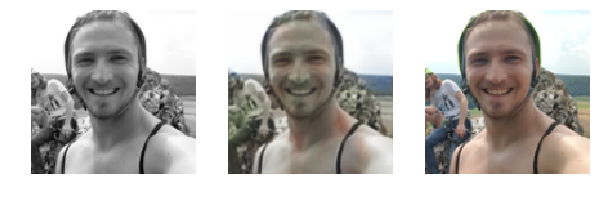

test color:
[0.37625736 0.40142184 0.35180438]
test color:
[0.36078432 0.4745098  0.25490198]


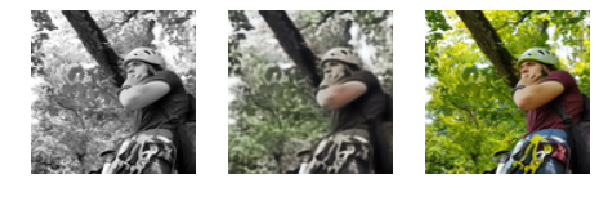

test color:
[0.4642613  0.49840254 0.44867456]
test color:
[0.48235294 0.5568628  0.19607843]


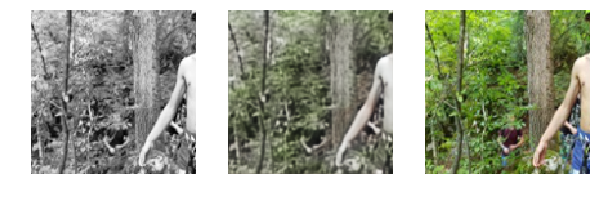

test color:
[0.21887766 0.22830547 0.20231725]
test color:
[0.1764706  0.20784314 0.04705882]


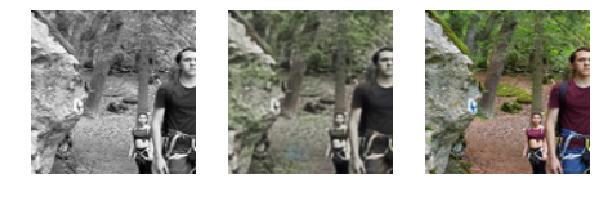

In [0]:
model=model.cpu()
for i in range(4):
    img_gray, img_true = dataset[i]
    img_gray=img_gray.cpu()
    img_true=img_true.cpu()
    
    img_pred = model(img_gray.view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

test color:
[0.5607231  0.5983937  0.52799267]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


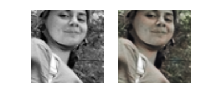

In [0]:
model.cuda()
img_gray, img_true = dataset[1]
img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
img_pred = to_numpy_image(img_pred)
img_gray=img_gray.cpu()

plt.subplot(141)
plt.axis('off')
plt.set_cmap('Greys')
plt.imshow(img_gray.reshape((128, 128)))

plt.subplot(142)
plt.axis('off')
plt.imshow(img_pred.reshape((128, 128, 3)))